In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

im = cv2.imread("M-06_Warren_sat.png")
im = cv2.imread("A-02_Minot_sat.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
ref_number = (int(im.shape[0] / 2), int(im.shape[1] / 2)) # center pixel
tolerance = 20 # tolerance range for pixel difference check

print(ref_number)

(177, 109)


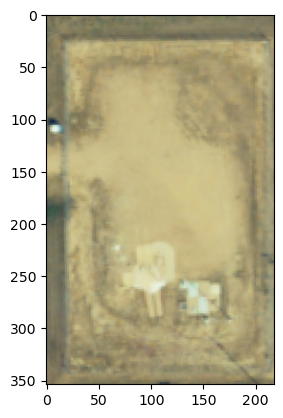

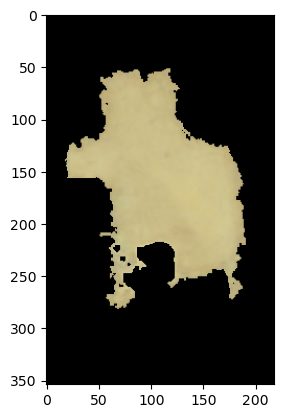

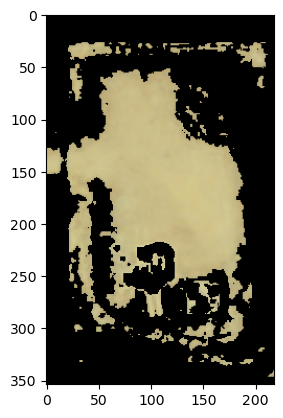

In [4]:
def magic_wand(image, reference, tolerance, contiguous = True):
    '''
    A function similar to Photoshop's "magic wand" tool, used to select
    pixels with similar values
    
    ***Inputs***
    image:      RGB or RGBA image array
    reference:  either a 2 or 3 number tuple containing a pixel location 
                or a pixel value, respectively
    tolerance:  integer value defining the +/- range for acceptable pixel values
    contiguous: boolean value defining whether to only return contigous pixels

    ***Outputs***
    mask:       Returns a 1-dimensional numpy array uint8 mask of contiguous or non-contiguous
                pixels with R, G, B values that fall within the +/- tolerance range
    '''
    def bound(value):
        return max(0, min(255, value))
    
    def get_adjacent(ref_number):
        adjacent_nums = []
        adjacent_nums.append((ref_number[0] - 1, ref_number[1]))
        adjacent_nums.append((ref_number[0] + 1, ref_number[1]))
        adjacent_nums.append((ref_number[0] - 1, ref_number[1] - 1))
        adjacent_nums.append((ref_number[0], ref_number[1] - 1))
        adjacent_nums.append((ref_number[0] + 1, ref_number[1] - 1))
        adjacent_nums.append((ref_number[0] - 1, ref_number[1] + 1))
        adjacent_nums.append((ref_number[0], ref_number[1] + 1))
        adjacent_nums.append((ref_number[0] + 1, ref_number[1] + 1))
        return adjacent_nums
        
    def mark_adjacent(ref_number):
        adjacent_nums = get_adjacent(ref_number) # get references of adjacent pixels
        for adjacent_num in adjacent_nums:
            if (np.array(adjacent_num) >= 0).all() and (np.array(adjacent_num) < im.shape[:2]).all(): # in-bounds check
                current_ref_pixel = im[*adjacent_num, :3]
                if (current_ref_pixel > [bound(i - tolerance) for i in ref_pixel]).all() and (current_ref_pixel < [bound(i + tolerance) for i in ref_pixel]).all(): # in-tolerance and between 0 & 255 check
                    mask[adjacent_num] = 1
        
    im = np.array(deepcopy(image).astype('uint8'))
    
    if len(reference) > 2: # pixel value provided
        ref_pixel = reference
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                current_ref_pixel = im[i, j, :3]
                if (current_ref_pixel > [bound(i - 1) for i in ref_pixel]).all() and (current_ref_pixel < [bound(i + 1) for i in ref_pixel]).all():
                    ref_number = (i, j) # get and store pixel location with reference pixel value
                    break
                if (i == range(im.shape[0])) and (j == range(im.shape[1])):
                    raise Exception("No pixels match provided reference")
            else:
                continue
            break
                    
    elif len(reference) == 2: # pixel location provided
        ref_number = reference
        ref_pixel = im[*ref_number, :3] # get and store reference pixel value
    else:
        raise Exception("Cannot parse provided reference")
        
    if contiguous:
        mask = np.zeros_like(im[:, :, 0]) # make an array of zeros in the shape of one of the color channels of the original im
        mask[*ref_number] = 1 # mark the starting pixel as 1
        
        # Top
        i = 0
        while ref_number[0] - i > 0:
            j = 0
            while ref_number[1] - j > 0:
                if mask[ref_number[0] - i, ref_number[1] - j] == 1:
                    mark_adjacent((ref_number[0] - i, ref_number[1] - j))
                j = j + 1
            j = 0
            while ref_number[1] + j < im.shape[1]:
                if mask[ref_number[0] - i, ref_number[1] + j] == 1:
                    mark_adjacent((ref_number[0] - i, ref_number[1] + j))
                j = j + 1
            i = i + 1
    
        # Bottom
        i = 0
        while ref_number[0] + i < im.shape[0]:
            j = 0
            while ref_number[1] - j > 0:
                if mask[ref_number[0] + i, ref_number[1] - j] == 1:
                    mark_adjacent((ref_number[0] + i, ref_number[1] - j))
                j = j + 1
            j = 0
            while ref_number[1] + j < im.shape[1]:
                if mask[ref_number[0] + i, ref_number[1] + j] == 1:
                    mark_adjacent((ref_number[0] + i, ref_number[1] + j))
                j = j + 1
            i = i + 1
                
        return mask
    else:
        mask = np.zeros_like(im[:, :, 0]) # make an array of zeros in the shape of one of the color channels of the original im
        
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                current_ref_pixel = im[i, j, :3]
                if (current_ref_pixel > [bound(i - tolerance) for i in ref_pixel]).all() and (current_ref_pixel < [bound(i + tolerance) for i in ref_pixel]).all(): # in-tolerance and between 0 & 255 check
                    mask[i, j] = 1
        return mask

location_mask = magic_wand(im, ref_number, tolerance, contiguous = True)
value_mask = magic_wand(im, (201, 188, 135), tolerance, contiguous = False)
new_im_location = cv2.bitwise_and(im, im, mask = location_mask)
new_im_value = cv2.bitwise_and(im, im, mask = value_mask)
plt.imshow(im)
plt.show()
plt.imshow(new_im_location)
plt.show()
plt.imshow(new_im_value)
plt.show()